$\textbf{PROGRAMMING ASSIGNMENT}$
---

Data: https://archive.ics.uci.edu

Instructions: Choose a dataset of your liking and perform the following:

1. Create a Correlation Plot

2. Check the distribution of each column and determine which probability distiribution it fits.

3. Create a summary statistics.

4. Perform a hypothesis test (Code from scratch).

In [81]:
# Library Imports
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo 
from scipy.stats import chi2

In [82]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
land_mines = fetch_ucirepo(id=763) 
  
# data (as pandas dataframes) 
X = land_mines.data.features 
y = land_mines.data.targets 
  
# metadata 
print(land_mines.metadata) 
  
# variable information 
print(land_mines.variables) 

{'uci_id': 763, 'name': 'Land Mines', 'repository_url': 'https://archive.ics.uci.edu/dataset/763/land+mines-1', 'data_url': 'https://archive.ics.uci.edu/static/public/763/data.csv', 'abstract': 'Detection of mines buried in the ground is very important in terms of safety of life and property. Many different methods have been used in this regard; however, it has not yet been possible to achieve 100% success. Mine detection process consists of sensor design, data analysis and decision algorithm phases. The magnetic anomaly method works according to the principle of measuring the anomalies resulting from the object in the magnetic field that disturbs the structure of it, the magnetic field, and the data obtained at this point are used to determine the conditions such as motion and position. The determination of parameters such as position, depth or direction of motion using magnetic anomaly has been carried out since 1970.', 'area': 'Engineering', 'tasks': ['Classification', 'Clustering']

In [83]:
X.head()

,V,H,S
0,0.338157,0.000000,0.0
1,0.320241,0.181818,0.0
2,0.287009,0.272727,0.0
3,0.256284,0.454545,0.0
4,0.262840,0.545455,0.0


In [84]:
# --- CREATING A CORRELATION PLOT --- 

data = pd.DataFrame(X, columns=land_mines.feature_names)
data['M'] = y  

data.fillna('Missing', inplace=True)

categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

correlation_matrix = data.corr()

mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

df_corr_viz = correlation_matrix.mask(mask).dropna(how='all').dropna(axis=1, how='all')

fig = px.imshow(df_corr_viz, text_auto=True)
fig.update_layout(height=900, width=900)
fig.show()

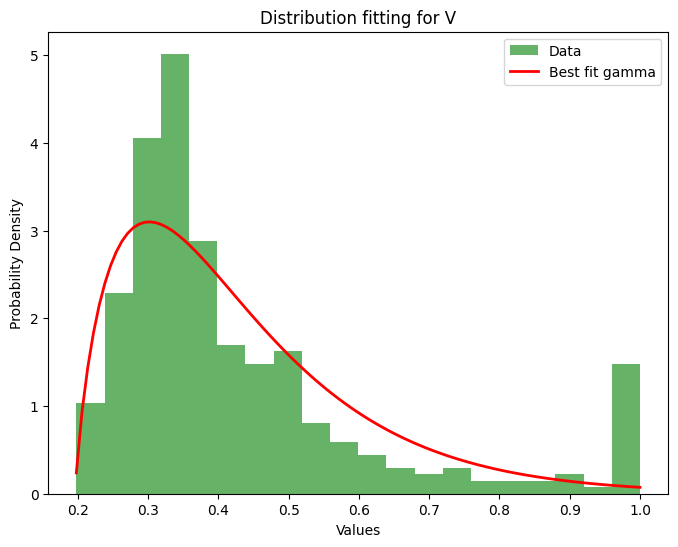

Best fitting distribution for V: gamma
Parameters: (1.8152374729566265, 0.1960485334589015, 0.12923016909347518)


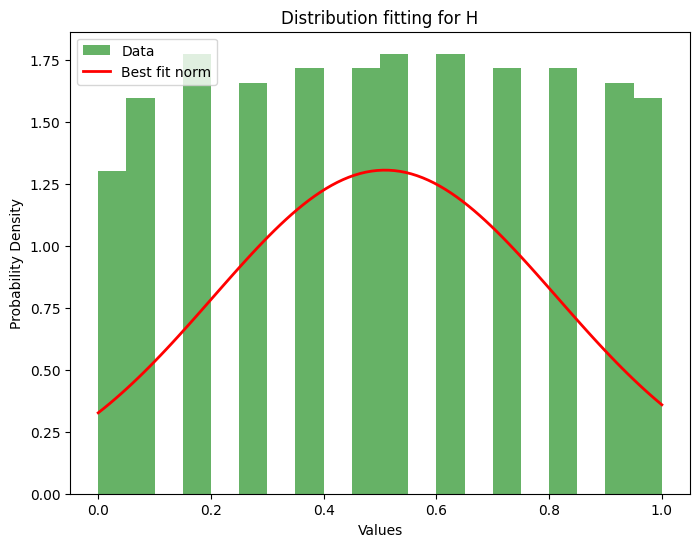

Best fitting distribution for H: norm
Parameters: (0.5088757396420118, 0.3055903291134881)


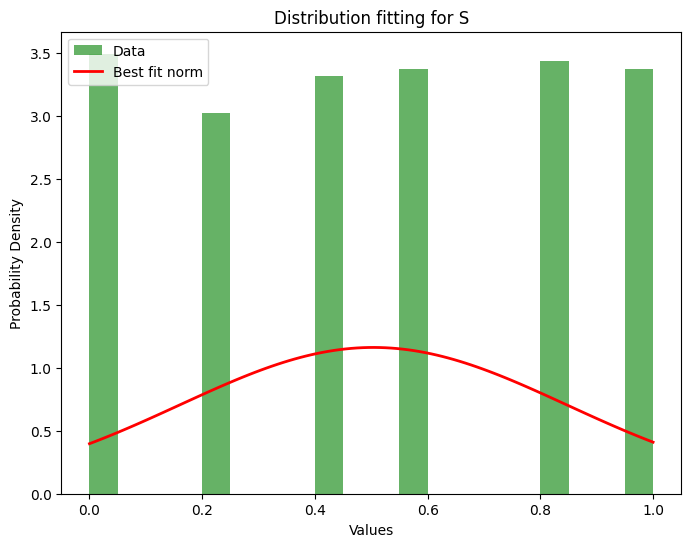

Best fitting distribution for S: norm
Parameters: (0.5035502958579882, 0.3437340190797145)


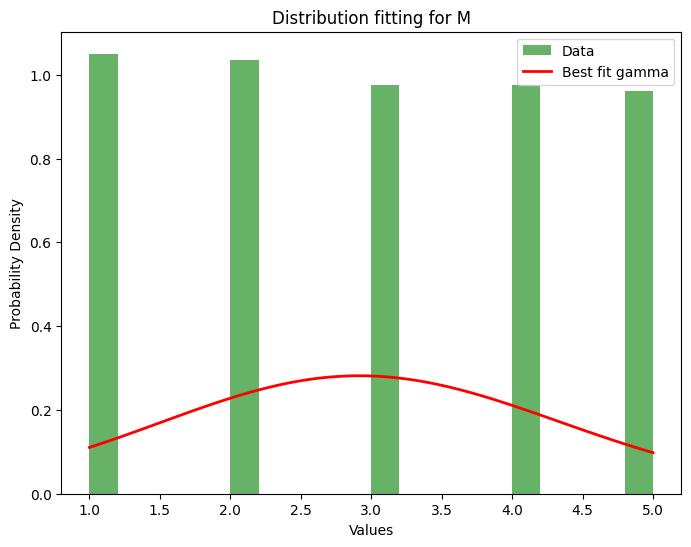

Best fitting distribution for M: gamma
Parameters: (1469.8120600765878, -51.38306801121169, 0.03696742590756494)

Total distribution counts:
norm: 2
expon: 0
gamma: 2


In [85]:
# --- PROBABILITY DISTRIBUTION --- 


data = pd.DataFrame(X, columns=land_mines.feature_names)
data['M'] = y  

data.fillna('Missing', inplace=True)

categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

distributions = ['norm', 'expon', 'gamma']

distribution_counts = {dist_name: 0 for dist_name in distributions}

for column in data.columns:
    data_col = data[column]
    
    if pd.api.types.is_numeric_dtype(data_col):
        data_col = data_col.dropna() 
        
        best_fit_name = ''
        best_fit_params = {}
        best_kstest_stat = np.inf
        
        for dist_name in distributions:
            dist = getattr(stats, dist_name)
            params = dist.fit(data_col)
            kstest_stat, _ = stats.kstest(data_col, dist_name, args=params)
            
            if kstest_stat < best_kstest_stat:
                best_fit_name = dist_name
                best_fit_params = params
                best_kstest_stat = kstest_stat
        
        distribution_counts[best_fit_name] += 1
        
        plt.figure(figsize=(8, 6))
        plt.hist(data_col, bins=20, density=True, alpha=0.6, color='g', label='Data')
        
        dist = getattr(stats, best_fit_name)
        x = np.linspace(min(data_col), max(data_col), 100)
        pdf = dist.pdf(x, *best_fit_params)
        plt.plot(x, pdf, 'r-', lw=2, label='Best fit ' + best_fit_name)
        
        plt.title('Distribution fitting for {}'.format(column))
        plt.xlabel('Values')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.show()
    
        print('Best fitting distribution for {}: {}'.format(column, best_fit_name))
        print('Parameters:', best_fit_params)


print('\nTotal distribution counts:')
for dist_name, count in distribution_counts.items():
    print('{}: {}'.format(dist_name, count))

In [86]:
# --- SUMMARY STATISTICS --- 

summary_statistics = data.describe()

print(summary_statistics)

                V           H           S           M
count  338.000000  338.000000  338.000000  338.000000
mean     0.430634    0.508876    0.503550    2.952663
std      0.195819    0.306043    0.344244    1.419703
min      0.197734    0.000000    0.000000    1.000000
25%      0.309737    0.272727    0.200000    2.000000
50%      0.359516    0.545455    0.600000    3.000000
75%      0.482628    0.727273    0.800000    4.000000
max      0.999999    1.000000    1.000000    5.000000


$\textbf{HYPOTHESIS TEST}$

$\textbf{The Correlation Between V (Voltage) and H(Height) of Landmine}$

Null Hypothesis (H0): There is no correlation between Voltage and Height attainment.

Alternative Hypothesis (H1): There is a correlation between Voltage and Height attainment.

In [87]:
data = X.dropna(subset=['V', 'H'])

contingency_table = pd.crosstab(data['V'], data['H'])

row_totals = contingency_table.sum(axis=1)
column_totals = contingency_table.sum(axis=0)
total = contingency_table.values.sum()

expected_counts = pd.DataFrame(
    [[(row_total * column_total) / total for column_total in column_totals]
     for row_total in row_totals],
    index=contingency_table.index,
    columns=contingency_table.columns
)

chi_squared_stat = ((contingency_table - expected_counts) ** 2 / expected_counts).values.sum()

num_rows = contingency_table.shape[0] - 1
num_columns = contingency_table.shape[1] - 1
degrees_of_freedom = num_rows * num_columns

p_value = chi2.sf(chi_squared_stat, degrees_of_freedom)

print("Chi-squared Statistic: ", chi_squared_stat)
print("Degrees of Freedom: ", degrees_of_freedom)
print("P-Value: ", p_value, "\n")

if p_value < 0.05:
    print("The null hypothesis is rejected. There is a significant difference in the distribution of 'V' across different 'H' categories.")
else:
    print("Failed to reject the null hypothesis. There is no significant difference in the distribution of 'V' across different 'H' categories.")

Chi-squared Statistic:  2225.0226239273916
Degrees of Freedom:  2145
P-Value:  0.1117961085590583 

Failed to reject the null hypothesis. There is no significant difference in the distribution of 'V' across different 'H' categories.
